In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import xgboost as xgb
import optuna

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

In [2]:
# set visibility for all the columns
pd.set_option('display.max_columns', None)

In [3]:
# Load the datasets
df = pd.read_csv('data/Training_dataset.csv')
test_df = pd.read_csv('data/Test_dataset.csv')

In [4]:
def missing_data_info(df):
    total_missing = df.isnull().sum()
    percent_missing = (df.isnull().sum() / df.shape[0]) * 100
    
    # Combine the results into a DataFrame and sort by the 'Percent' column
    missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
    missing_data = missing_data[missing_data['Percent'] > 0].sort_values(by='Percent', ascending=False)
    
    return missing_data

In [5]:
missing_data_info(test_df)

,Total,Percent
VehColorInt,108,10.8
VehDriveTrain,64,6.4
VehEngine,58,5.8
VehSellerNotes,41,4.1
VehPriceLabel,38,3.8
VehFeats,37,3.7
VehHistory,27,2.7
VehTransmission,27,2.7
VehColorExt,7,0.7
VehMileage,1,0.1


In [6]:
imputation_features = ['VehColorExt','VehColorInt','VehDriveTrain','VehEngine','VehFeats','VehHistory','VehMileage',
                      'VehPriceLabel','VehSellerNotes','VehTransmission']

In [7]:
test_df.shape

(1000, 27)

# Frame the problem
The problem is:
- Regression: predict the price at which car was listed by the dealer
- Classification: classify the value of the trim

We are dealing with:
- [Cadillac XT5](https://en.wikipedia.org/wiki/Cadillac_XT5) </br>
- [Jeep Grand Cherokee (WK2)](https://en.wikipedia.org/wiki/Jeep_Grand_Cherokee_%28WK2%29)

### Small Theory

#### Cadilac XT5
1. Trim levels ( 4 kinds)
- Base
- Luxury
- Premium Luxury
- Platinum

#### Jeep Cherokee
2. Trim levels (many)
- Laredo
- Laredo E
- Upland
- Laredo X
- Trail Hawk
- Limited
- Sterling Edition
- Overland
- Overland Summit/ Summit
- SRT
- Trackhawk

- Regression: RMSE
- Classification: AUC

# Data Exploration - train/ validation data

In [8]:
df.shape

(6298, 29)

In [9]:
df.head(2)

,ListingID,SellerCity,SellerIsPriv,SellerListSrc,SellerName,SellerRating,SellerRevCnt,SellerState,SellerZip,VehBodystyle,VehCertified,VehColorExt,VehColorInt,VehDriveTrain,VehEngine,VehFeats,VehFuel,VehHistory,VehListdays,VehMake,VehMileage,VehModel,VehPriceLabel,VehSellerNotes,VehType,VehTransmission,VehYear,Vehicle_Trim,Dealer_Listing_Price
0,3287,Warren,False,Inventory Command Center,Prime Motorz,5.0,32,MI,48091.0,SUV,False,White,Black,4X4,3.6L V6,"['Adaptive Cruise Control', 'Antilock Brakes',...",Gasoline,"1 Owner, Non-Personal Use Reported, Buyback Pr...",8.600069,Jeep,39319.0,Grand Cherokee,Fair Price,NaN,Used,Automatic 8-Speed,2015,High Altitude,30990.0
1,3920,Fargo,False,Cadillac Certified Program,Gateway Chevrolet Cadillac,4.8,1456,ND,58103.0,SUV,True,Black,NaN,NaN,NaN,NaN,Gasoline,"1 Owner, Buyback Protection Eligible",2.920127,Cadillac,30352.0,XT5,Good Deal,Come take a look at our great pre-owned invent...,Used,NaN,2017,NaN,34860.0


In [10]:
df.set_index('ListingID', inplace=True)

In [11]:
df.columns

Index(['SellerCity', 'SellerIsPriv', 'SellerListSrc', 'SellerName',
       'SellerRating', 'SellerRevCnt', 'SellerState', 'SellerZip',
       'VehBodystyle', 'VehCertified', 'VehColorExt', 'VehColorInt',
       'VehDriveTrain', 'VehEngine', 'VehFeats', 'VehFuel', 'VehHistory',
       'VehListdays', 'VehMake', 'VehMileage', 'VehModel', 'VehPriceLabel',
       'VehSellerNotes', 'VehType', 'VehTransmission', 'VehYear',
       'Vehicle_Trim', 'Dealer_Listing_Price'],
      dtype='object')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6298 entries, 3287 to 8620012
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   SellerCity            6298 non-null   object 
 1   SellerIsPriv          6298 non-null   bool   
 2   SellerListSrc         6296 non-null   object 
 3   SellerName            6298 non-null   object 
 4   SellerRating          6298 non-null   float64
 5   SellerRevCnt          6298 non-null   int64  
 6   SellerState           6298 non-null   object 
 7   SellerZip             6296 non-null   float64
 8   VehBodystyle          6298 non-null   object 
 9   VehCertified          6298 non-null   bool   
 10  VehColorExt           6225 non-null   object 
 11  VehColorInt           5570 non-null   object 
 12  VehDriveTrain         5897 non-null   object 
 13  VehEngine             5937 non-null   object 
 14  VehFeats              6023 non-null   object 
 15  VehFuel        

In [13]:
duplicate_count = df[df.duplicated()].shape[0]
print(f"There are {duplicate_count} duplicate rows.")

There are 0 duplicate rows.


# 1.Target variables
- show missing values
- delete missing values

In [14]:
target_variables = ['Vehicle_Trim','Dealer_Listing_Price']

In [15]:
missing_data_info(df)

,Total,Percent
VehColorInt,728,11.559225
Vehicle_Trim,405,6.430613
VehDriveTrain,401,6.367101
VehEngine,361,5.731978
VehPriceLabel,285,4.525246
VehFeats,275,4.366466
VehSellerNotes,243,3.858368
VehHistory,201,3.191489
VehTransmission,197,3.127977
VehColorExt,73,1.159098


In [16]:
# dropping target NaN's as we cant do anything about them 
df = df.dropna(subset=['Vehicle_Trim', 'Dealer_Listing_Price'])

In [17]:
y = df[target_variables]

In [18]:
y.head(4)

,Vehicle_Trim,Dealer_Listing_Price
ListingID,,
3287,High Altitude,30990.0
4777,Laredo,23249.0
6242,Limited,31977.0
7108,Luxury,33495.0


In [19]:
df.shape

(5841, 28)

# 2. EDA - target variables

### Target variables - `Vehicle_Trim`

In [20]:
# Get unique trims for Jeep
jeep_trims = df[df['VehMake'] == 'Jeep']['Vehicle_Trim'].unique()
jeep_trims_df = pd.DataFrame({'Jeep Trims' : pd.Series(jeep_trims)})

# Get unique trims for Cadillac
cadillac_trims = df[df['VehMake'] == 'Cadillac']['Vehicle_Trim'].unique()
cadilac_trims_df = pd.DataFrame({'Jeep Trims' : pd.Series(cadillac_trims)})

def value_counts_info(df):
    all_data = []
    
    for column in df.columns:
        counts = df[column].value_counts()
        percent = (df[column].value_counts() / df.shape[0]) * 100
        
        data = pd.concat([counts, percent], axis=1, keys=['Counts', 'Percent']).reset_index()
        data.rename(columns={'index': 'Value'}, inplace=True)
        data['Column'] = column
        all_data.append(data)
        print('Total count: ',counts.sum())
        
    final_df = pd.concat(all_data, axis=0, ignore_index=True).pivot_table(index=['Column', 'Value'], values=['Counts', 'Percent'], aggfunc='first')
    final_df = final_df.sort_values(by='Percent', ascending=False)

    return final_df

### 2.1. Jeeps

#### Jeep Cherokee
1. Trim levels (many)
- Laredo
- Laredo E
- Upland
- Laredo X
- Trail Hawk
- Limited
- Sterling Edition
- Overland
- Overland Summit/ Summit
- SRT
- Trackhawk

In [21]:
jeep_trims_df

,Jeep Trims
0,High Altitude
1,Laredo
2,Limited
3,Limited 4x4
4,Altitude
5,Overland
6,Summit
7,SRT
8,Trailhawk
9,Sterling Edition


In [22]:
# Jeep
value_counts_info(pd.DataFrame(df[df['VehMake'] == 'Jeep']['Vehicle_Trim']))

Total count:  4030


Counts    Percent
Column       Value                                              
Vehicle_Trim Limited                             1912  47.444169
             Laredo                               704  17.468983
             Overland                             381   9.454094
             Altitude                             325   8.064516
             Summit                               242   6.004963
             Trailhawk                            178   4.416873
             High Altitude                         86   2.133995
             SRT                                   76   1.885856
             Laredo E                              47   1.166253
             Trackhawk                             30   0.744417
             Sterling Edition                      26   0.645161
             75th Anniversary                       8   0.198511
             Limited 75th Anniversary Edition       5   0.124069
             SRT Night                              3   0.074442
             Upland                                 3   0.074442
             Limited X                              1   0.024814
             75th Anniversary Edition               1   0.024814
             Limited 75th Anniversary               1   0.024814
             Limited 4x4                            1   0.024814

In [23]:
# Mapping dictionary
mapping = {
    'Limited 75th Anniversary Edition': 'Limited',
    'Limited X': 'Limited',
    'Limited 4x4': 'Limited',
    'Limited 75th Anniversary': 'Limited',

    'Laredo E': 'Laredo',

    'SRT Night': 'SRT',
    
    'Summit': 'Overland',

    'Trackhawk': 'Trailhawk',
    
    'High Altitude': 'Altitude'}

# Replace and groupby
df['Vehicle_Trim'] = df['Vehicle_Trim'].replace(mapping)
# dropping 
jeep_drop_trims = ['75th Anniversary Edition', 'Upland','75th Anniversary','Sterling Edition']

original_row_count = len(df)
df = df[~df['Vehicle_Trim'].isin(jeep_drop_trims)]

# Calculate the number of removed rows
removed_rows_count = original_row_count - len(df)
print(removed_rows_count)

38


In [24]:
value_counts_info(pd.DataFrame(df[df['VehMake'] == 'Jeep']['Vehicle_Trim']))

Total count:  3992


Counts    Percent
Column       Value                       
Vehicle_Trim Limited      1920  48.096192
             Laredo        751  18.812625
             Overland      623  15.606212
             Altitude      411  10.295591
             Trailhawk     208   5.210421
             SRT            79   1.978958

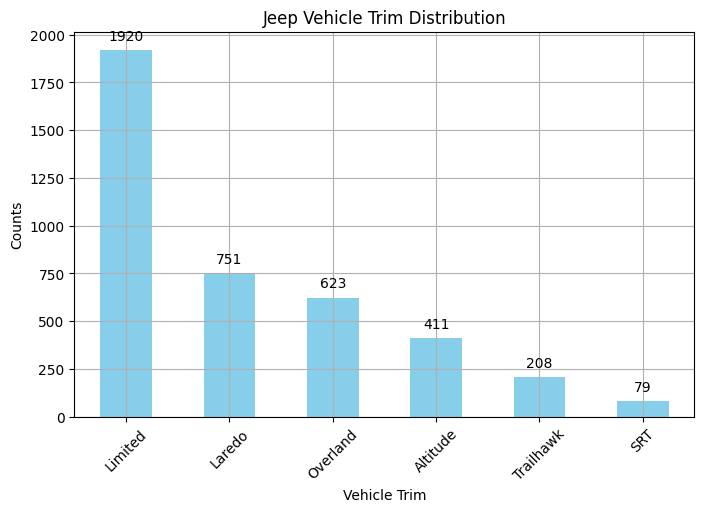

In [25]:
jeep_trims = df[df['VehMake'] == 'Jeep']['Vehicle_Trim'].value_counts()

# Plotting the bar chart
ax = jeep_trims.plot(kind='bar', color='skyblue', figsize=(8,5))
plt.xlabel('Vehicle Trim')
plt.ylabel('Counts')
plt.title('Jeep Vehicle Trim Distribution')
plt.grid()
plt.xticks(rotation=45)

# Adding count annotations to each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

### 2.2. Cadillac

#### Cadillac XT5
1. Trim levels ( 4 kinds)
- Base
- Luxury
- Premium Luxury
- Platinum


In [26]:
cadilac_trims_df

,Jeep Trims
0,Luxury
1,Premium Luxury
2,Base
3,FWD
4,Luxury AWD
5,Platinum
6,Luxury FWD
7,Premium Luxury FWD
8,Platinum AWD
9,Premium Luxury AWD


In [27]:
# Cadilac
value_counts_info(pd.DataFrame(df[df['VehMake'] == 'Cadillac']['Vehicle_Trim']))

Total count:  1811


Counts    Percent
Column       Value                                
Vehicle_Trim Premium Luxury         733  40.474876
             Luxury                 622  34.345665
             Base                   154   8.503589
             Platinum               127   7.012700
             FWD                     49   2.705687
             Luxury FWD              49   2.705687
             Premium Luxury FWD      35   1.932634
             Luxury AWD              20   1.104362
             Platinum AWD            13   0.717835
             Premium Luxury AWD       9   0.496963

In [28]:
# Mapping dictionary
mapping = {
    'Premium Luxury AWD': 'Premium',
    'Premium Luxury FWD': 'Premium',
    'Premium Luxury': 'Premium',
    
    'Luxury FWD': 'Luxury',
    'Luxury': 'Luxury',
    'Luxury AWD': 'Luxury',
    
    'Base': 'Base',
    'FWD': 'Base',
    
    'Platinum': 'Platinum',
    'Platinum AWD': 'Platinum'}

# Replace and groupby
df['Vehicle_Trim'] = df['Vehicle_Trim'].replace(mapping)

# dropping 
# cadillac_drop_trims = ['NaN']

# original_row_count = len(df)
# df = df[~df['Vehicle_Trim'].isin(cadillac_drop_trims)]

# # Calculate the number of removed rows
# removed_rows_count = original_row_count - len(df)
# print(removed_rows_count)

In [29]:
value_counts_info(pd.DataFrame(df[df['VehMake'] == 'Cadillac']['Vehicle_Trim']))

Total count:  1811


Counts    Percent
Column       Value                      
Vehicle_Trim Premium      777  42.904473
             Luxury       691  38.155715
             Base         203  11.209277
             Platinum     140   7.730536

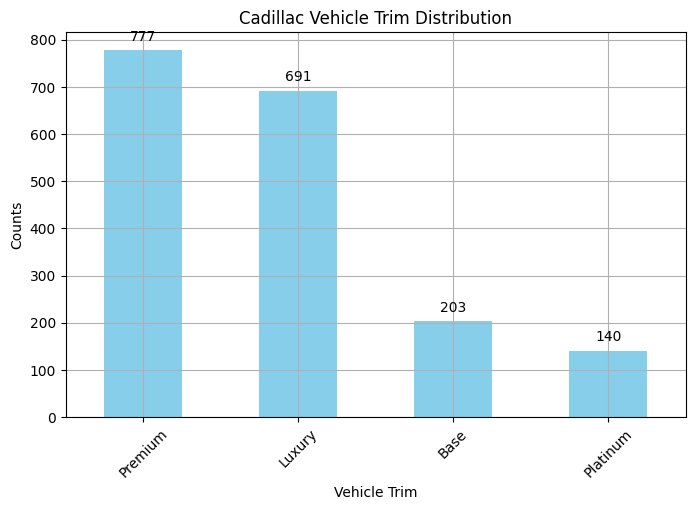

In [30]:
jeep_trims = df[df['VehMake'] == 'Cadillac']['Vehicle_Trim'].value_counts()

# Plotting the bar chart
ax = jeep_trims.plot(kind='bar', color='skyblue', figsize=(8,5))
plt.xlabel('Vehicle Trim')
plt.ylabel('Counts')
plt.title('Cadillac Vehicle Trim Distribution')
plt.grid()
plt.xticks(rotation=45)

# Adding count annotations to each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

In [31]:
df.shape

(5803, 28)

In [32]:
value_counts_info(pd.DataFrame(df[['Vehicle_Trim']]))

Total count:  5803


Counts    Percent
Column       Value                       
Vehicle_Trim Limited      1920  33.086335
             Premium       777  13.389626
             Laredo        751  12.941582
             Luxury        691  11.907634
             Overland      623  10.735826
             Altitude      411   7.082544
             Trailhawk     208   3.584353
             Base          203   3.498191
             Platinum      140   2.412545
             SRT            79   1.361365

In [33]:
df['Vehicle_Trim'].isnull().sum()

0

### Target Variable - `Dealer_Listing_Price`

In [34]:
y.Dealer_Listing_Price.describe()

count     5841.000000
mean     32059.815614
std       7568.389098
min      18289.000000
25%      26750.000000
50%      30996.000000
75%      35873.000000
max      89500.000000
Name: Dealer_Listing_Price, dtype: float64

In [35]:
cad_price = df[df['VehMake'] == 'Cadillac']['Dealer_Listing_Price']
jeep_price = df[df['VehMake'] == 'Jeep']['Dealer_Listing_Price']

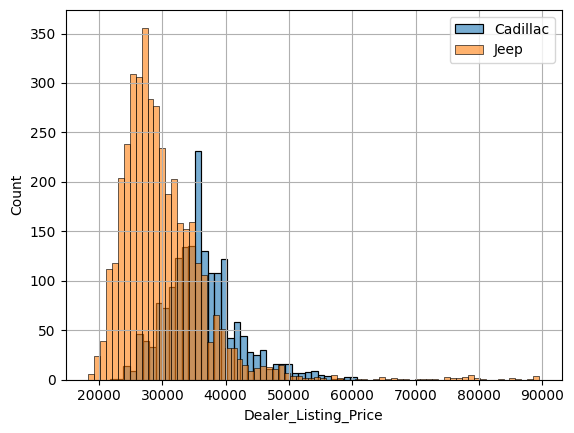

In [36]:
plt.figure()
sns.histplot(cad_price, label='Cadillac', alpha=0.6)
sns.histplot(jeep_price, label='Jeep',alpha=0.6)
plt.legend()
plt.grid()
plt.show()

# 3. EDA - features

In [37]:
target_variables

['Vehicle_Trim', 'Dealer_Listing_Price']

In [38]:
df.shape

(5803, 28)

In [39]:
df.head(2)

,SellerCity,SellerIsPriv,SellerListSrc,SellerName,SellerRating,SellerRevCnt,SellerState,SellerZip,VehBodystyle,VehCertified,VehColorExt,VehColorInt,VehDriveTrain,VehEngine,VehFeats,VehFuel,VehHistory,VehListdays,VehMake,VehMileage,VehModel,VehPriceLabel,VehSellerNotes,VehType,VehTransmission,VehYear,Vehicle_Trim,Dealer_Listing_Price
ListingID,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3287,Warren,False,Inventory Command Center,Prime Motorz,5.0,32,MI,48091.0,SUV,False,White,Black,4X4,3.6L V6,"['Adaptive Cruise Control', 'Antilock Brakes',...",Gasoline,"1 Owner, Non-Personal Use Reported, Buyback Pr...",8.600069,Jeep,39319.0,Grand Cherokee,Fair Price,NaN,Used,Automatic 8-Speed,2015,Altitude,30990.0
4777,Waukesha,False,Jeep Certified Program,Wilde Chrysler Jeep Dodge Ram &amp; Subaru,4.8,1405,WI,53186.0,SUV,True,Brilliant Black Crystal Pearlcoat,Black,4x4/4WD,Regular Unleaded V-6 3.6 L/220,['18 WHEEL &amp; 8.4 RADIO GROUP-inc: Nav-Capa...,Gasoline,"1 Owner, Buyback Protection Eligible",28.107014,Jeep,38957.0,Grand Cherokee,Good Deal,Backed by a rigorous 125-point inspection by f...,Used,8-Speed Automatic w/OD,2015,Laredo,23249.0


In [40]:
x = df.copy()#.drop(columns=target_variables)

In [41]:
missing_data_info(x)

,Total,Percent
VehColorInt,421,7.254868
VehPriceLabel,233,4.015165
VehHistory,197,3.394796
VehSellerNotes,74,1.275202
VehDriveTrain,68,1.171808
VehColorExt,42,0.723764
VehTransmission,32,0.551439
VehEngine,28,0.482509
VehFeats,23,0.396347
SellerListSrc,2,0.034465


In [42]:
x = x.dropna()
print(x.shape)

(5012, 28)


In [43]:
missing_data_info(x)

,Total,Percent


In [44]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5012 entries, 4777 to 8620012
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   SellerCity            5012 non-null   object 
 1   SellerIsPriv          5012 non-null   bool   
 2   SellerListSrc         5012 non-null   object 
 3   SellerName            5012 non-null   object 
 4   SellerRating          5012 non-null   float64
 5   SellerRevCnt          5012 non-null   int64  
 6   SellerState           5012 non-null   object 
 7   SellerZip             5012 non-null   float64
 8   VehBodystyle          5012 non-null   object 
 9   VehCertified          5012 non-null   bool   
 10  VehColorExt           5012 non-null   object 
 11  VehColorInt           5012 non-null   object 
 12  VehDriveTrain         5012 non-null   object 
 13  VehEngine             5012 non-null   object 
 14  VehFeats              5012 non-null   object 
 15  VehFuel        

In [45]:
X_LEN = len(x)

In [46]:
numerical_features = []
categorical_features = []

In [47]:
def feature_analyzer(feature: str):
    if x[feature].dtype == 'O':
        print('Categorical feature')
        print('Number of Unique values:',len(x[feature].unique()))
        print(f'Missing values {x[feature].isnull().sum()}, % missing values {np.round(x[feature].isnull().sum()/X_LEN*100, 2)}')
        print()
        print('Unique Values:')
        print(x[feature].unique())
        
    elif x[feature].dtype == 'bool':
            print('Boolean feature')
            print(f'Missing values {x[feature].isnull().sum()}, % missing values {np.round(x[feature].isnull().sum()/X_LEN*100, 2)}')
            print(f"False count {len(x[feature])-x[feature].sum()}, True count {x[feature].sum()}")
    else:
        print('Numerical Feature')
        plt.figure()
        plt.title(feature)
        sns.histplot(x[feature], label=feature)
        plt.legend()
        plt.grid()
        plt.show()
        
        
def single_value_counts_info(feature):
    
    df = pd.DataFrame(x[feature])
    all_data = []
    
    for column in df.columns:
        counts = df[column].value_counts()
        percent = (df[column].value_counts() / df.shape[0]) * 100
        
        data = pd.concat([counts, percent], axis=1, keys=['Counts', 'Percent']).reset_index()
        data.rename(columns={'index': 'Value'}, inplace=True)
        data['Column'] = column
        all_data.append(data)
        print('Total count: ',counts.sum())
        
    final_df = pd.concat(all_data, axis=0, ignore_index=True).pivot_table(index=['Column', 'Value'], values=['Counts', 'Percent'], aggfunc='first')
    final_df = final_df.sort_values(by='Percent', ascending=False)

    return final_df

#### Going through each and every feature

1. `SellerCity`
- DROP: too many values 

In [48]:
feature_analyzer('SellerCity')

Categorical feature
Number of Unique values: 1129
Missing values 0, % missing values 0.0

Unique Values:
['Waukesha' 'Wentzville' 'Fayetteville' ... 'Sicklerville' 'Woodville'
 'Vincennes']


2. `SellerIsPriv`
- DROP: has only one value

In [49]:
feature_analyzer('SellerIsPriv')

Boolean feature
Missing values 0, % missing values 0.0
False count 5012, True count 0


3. SellerListSrc
- Added to categorical: one hot encoding

In [50]:
feature_analyzer('SellerListSrc')

Categorical feature
Number of Unique values: 5
Missing values 0, % missing values 0.0

Unique Values:
['Jeep Certified Program' 'Inventory Command Center' 'HomeNet Automotive'
 'Digital Motorworks (DMi)' 'My Dealer Center']


In [51]:
single_value_counts_info('SellerListSrc')

Total count:  5012


Counts    Percent
Column        Value                                      
SellerListSrc Digital Motorworks (DMi)    2639  52.653631
              Inventory Command Center     947  18.894653
              HomeNet Automotive           928  18.515563
              Jeep Certified Program       478   9.537111
              My Dealer Center              20   0.399042

In [52]:
categorical_features.append('SellerListSrc')

4. SellerName
- DROP

In [53]:
feature_analyzer('SellerName')

Categorical feature
Number of Unique values: 1964
Missing values 0, % missing values 0.0

Unique Values:
['Wilde Chrysler Jeep Dodge Ram &amp; Subaru'
 'Century Dodge Chrysler Jeep RAM' 'Superior Buick GMC of Fayetteville'
 ... 'Community Auto Sales' 'Cadillac of Dublin'
 'Foster Chevrolet Cadillac']


5. SellerRating
- added to numerical

Numerical Feature


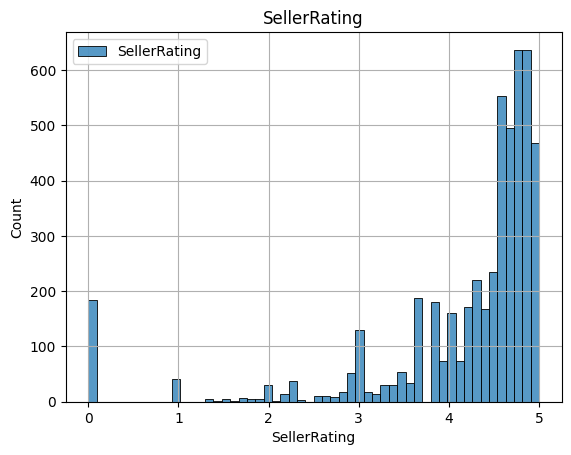

In [54]:
feature_analyzer('SellerRating')

In [55]:
numerical_features.append('SellerRating')

6. SellerRevCnt
- use log transform and add that as numerical

Numerical Feature


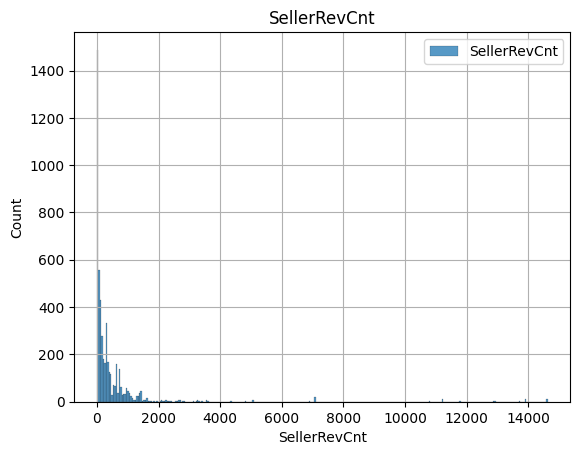

In [56]:
feature_analyzer('SellerRevCnt')

In [57]:
x['SellerRevCnt_log'] = np.log1p(x['SellerRevCnt']+1)

Numerical Feature


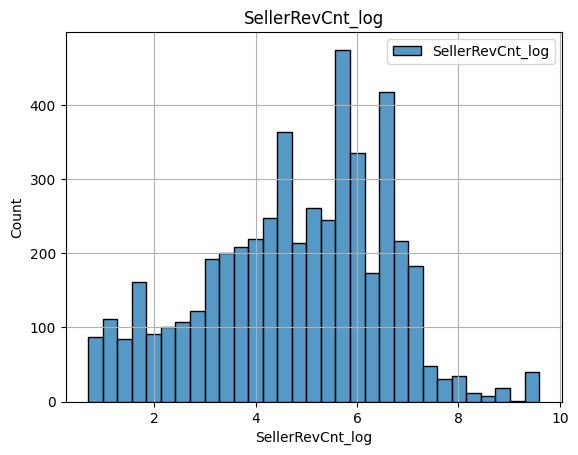

In [58]:
feature_analyzer('SellerRevCnt_log')

In [59]:
numerical_features.append('SellerRevCnt')

7. SellerState
- one hot

In [60]:
feature_analyzer('SellerState')

Categorical feature
Number of Unique values: 49
Missing values 0, % missing values 0.0

Unique Values:
['WI' 'MO' 'AR' 'NY' 'IL' 'KY' 'MD' 'LA' 'FL' 'TX' 'TN' 'OH' 'MI' 'IN'
 'NC' 'IA' 'UT' 'PA' 'OK' 'GA' 'VA' 'CO' 'MN' 'WV' 'KS' 'NJ' 'MA' 'DE'
 'SC' 'CA' 'AL' 'AK' 'CT' 'WA' 'SD' 'ID' 'NV' 'AZ' 'VT' 'MS' 'OR' 'NE'
 'NM' 'NH' 'MT' 'ME' 'ND' 'RI' 'HI']


In [61]:
single_value_counts_info('SellerState')

Total count:  5012


Counts    Percent
Column      Value                   
SellerState IL        613  12.230646
            OH        483   9.636872
            MI        456   9.098164
            WI        351   7.003192
            PA        266   5.307263
            NY        242   4.828412
            IN        233   4.648843
            TX        231   4.608939
            VA        195   3.890662
            MD        188   3.750998
            FL        184   3.671189
            MO        165   3.292099
            NC        158   3.152434
            MN        146   2.913009
            KY        141   2.813248
            GA        141   2.813248
            TN        130   2.593775
            IA        113   2.254589
            CA         86   1.715882
            NJ         65   1.296887
            CO         41   0.818037
            SC         40   0.798085
            WV         35   0.698324
            OK         31   0.618516
            WA         27   0.538707
            AL         26   0.518755
            LA         26   0.518755
            AZ         25   0.498803
            MA         21   0.418994
            AR         20   0.399042
            UT         19   0.379090
            NV         15   0.299282
            MS         14   0.279330
            CT         14   0.279330
            ID         13   0.259377
            SD         10   0.199521
            KS          9   0.179569
            OR          8   0.159617
            NH          6   0.119713
            DE          5   0.099761
            NM          4   0.079808
            NE          4   0.079808
            VT          3   0.059856
            AK          3   0.059856
            RI          2   0.039904
            ND          1   0.019952
            MT          1   0.019952
            ME          1   0.019952
            HI          1   0.019952

In [62]:
categorical_features.append('SellerState')

8. SellerZip
- drop, we already have the state 

Numerical Feature


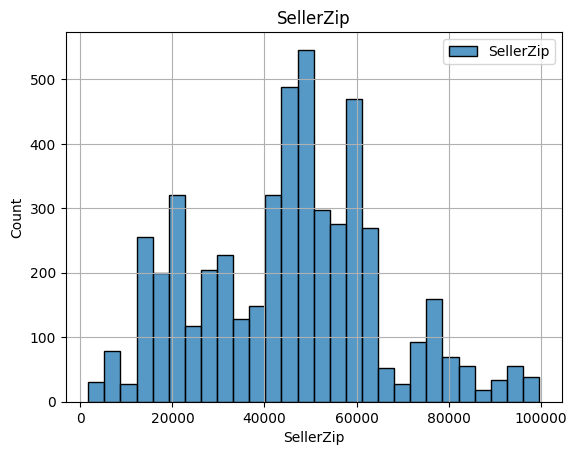

In [63]:
feature_analyzer('SellerZip')

9. VehBodystyle
- DROP: has one value only

In [64]:
feature_analyzer('VehBodystyle')

Categorical feature
Number of Unique values: 1
Missing values 0, % missing values 0.0

Unique Values:
['SUV']


 10. VehCertified
 - bool added 


In [65]:
feature_analyzer('VehCertified')

Boolean feature
Missing values 0, % missing values 0.0
False count 4102, True count 910


In [66]:
categorical_features.append('VehCertified')

 10. VehColorExt
 - categorical added, but extracted colors

In [67]:
feature_analyzer('VehColorExt')

Categorical feature
Number of Unique values: 142
Missing values 0, % missing values 0.0

Unique Values:
['Brilliant Black Crystal Pearlcoat' 'Diamond Black Crystal Pearlcoat'
 'Radiant Silver Metallic' 'Billet Silver Metallic Clearcoat'
 'True Blue Pearlcoat' 'Red' 'Bright White Clearcoat'
 'Billet Silver Metallic' 'Dark Granite Metallic' 'Crystal White Tricoat'
 'White' 'Red Passion Tintcoat' 'Granite Crystal Clearcoat Metallic'
 'Velvet Red Pearlcoat' 'Stellar Black Metallic' 'Gray'
 'Crystal White Tri-Coat' 'True Blue' 'Black'
 'Brilliant Black Crystal Pearl Coat' 'Granite Crystal Metallic Clearcoat'
 'Walnut Brown' 'Diamond Black' 'Maximum Steel Metallic Clearcoat'
 'Charcoal' 'Silver' 'Deep Cherry Red Crystal Pearlcoat'
 'Maximum Steel Metallic' 'Silver Black' 'Dark Adriatic Blue Metallic'
 'Velvet Red Pearl Coat' 'Blue' 'Bright White' 'Harbor Blue Metallic'
 'Deep Cherry Red Crystal' 'Maximum Steel'
 'Granite Crystal Metallic Clear Coat' 'Walnut Brown Metallic Clearcoat'
 'Black 

In [68]:
def basic_color(color):
    base_colors = ['Black', 'White', 'Red', 'Silver', 'Blue', 'Gray', 'Brown', 'Gold' ]
    for base in base_colors:
        if base.lower() in color.lower():
            return base
    return 'Other'

x['BasicExtColor'] = x['VehColorExt'].apply(basic_color)

In [69]:
single_value_counts_info('BasicExtColor')

Total count:  5012


Counts    Percent
Column        Value                    
BasicExtColor Black     1247  24.880287
              White     1035  20.650439
              Other      930  18.555467
              Silver     811  16.181165
              Red        533  10.634477
              Blue       241   4.808460
              Gray       155   3.092578
              Brown       55   1.097366
              Gold         5   0.099761

In [70]:
categorical_features.append('VehColorExt')

 11. VehColorInt
 - changed to boolean whether has leather or not


In [71]:
feature_analyzer('VehColorInt')

Categorical feature
Number of Unique values: 95
Missing values 0, % missing values 0.0

Unique Values:
['Black' 'Cirrus' 'Jet Black' 'Lt Frost Beige/Black' 'Tan' 'Black Leather'
 'Black / Dark Sienna Brown' 'Light Frost Beige / Black' 'Sahara Beige'
 'Shara Beige' 'TAN' 'lt frost beige black' 'Light Frost Beige'
 'Light Frost/Brown' 'black' 'BEIGE' 'Sepia / Black' 'Light Frost'
 'Beige Leather' 'Maple Sugar' 'Jet Black Lunar Brushed Aluminium Trim'
 'Beige' 'jet black' 'sahara beige' 'Sepia/Black' 'Ruby Red' 'JET BLACK'
 'Blue' 'Ruby Red/Black' 'JET BLACK BRONZE CARBON FIBER TRIM'
 'Sahara Beige w/ Jet Black Accent' 'Brown' 'Sahara Beige Leather'
 'Black/Dark Sienna Brown' 'Light Frost Beige/Black'
 'SAHARA BEIGE/JET BLACK ACCENTS NATURAL SAPELE HIGH' 'Brown/Indigo Blue'
 'Gray' 'Black / Light Frost Beige' 'Charcoal' 'Carbon Plum'
 'BLACK LEATHER' 'Other' 'Carbon' 'Ski Gray' 'Ski Gray/Indigo' 'BLACK'
 'BLACK/LIGHT FROST' 'Indigo Blue / Brown'
 'JET BLACK LUNAR BRUSHED ALUMINIUM TRIM'
 

In [72]:
x['ContainsLeather'] = x['VehColorInt'].str.contains('leather', case=False).astype(bool)

In [73]:
feature_analyzer('ContainsLeather')

Boolean feature
Missing values 0, % missing values 0.0
False count 4892, True count 120


In [74]:
categorical_features.append('VehColorInt')

 12. VehDriveTrain


In [75]:
feature_analyzer('VehDriveTrain')

Categorical feature
Number of Unique values: 15
Missing values 0, % missing values 0.0

Unique Values:
['4x4/4WD' '4WD' 'FWD' 'AWD' '4x4' 'Four Wheel Drive' '4X4'
 'All Wheel Drive'
 'ALL-WHEEL DRIVE WITH LOCKING AND LIMITED-SLIP DIFFERENTIAL' 'AWD or 4x4'
 'Front Wheel Drive' 'All-wheel Drive' 'ALL WHEEL' 'AllWheelDrive'
 '4WD/AWD']


In [76]:
drivetrain_mapping = {
    '4x4/4WD': 'all_drive',
    '4WD': 'all_drive',
    'FWD': 'front_drive',
    'AWD': 'all_drive',
    '4x4': 'all_drive',
    'Four Wheel Drive': 'all_drive',
    '4X4': 'all_drive',
    'All Wheel Drive': 'all_drive',
    'ALL-WHEEL DRIVE WITH LOCKING AND LIMITED-SLIP DIFFERENTIAL': 'all_drive',
    'AWD or 4x4': 'all_drive',
    'Front Wheel Drive': 'all_drive',
    'All-wheel Drive': 'all_drive',
    'ALL WHEEL': 'all_drive',
    'AllWheelDrive': 'all_drive',
    '4WD/AWD': 'all_drive'
}

x['Drivetrain'] = x['VehDriveTrain'].replace(drivetrain_mapping).astype('O')

In [77]:
feature_analyzer('Drivetrain')

Categorical feature
Number of Unique values: 2
Missing values 0, % missing values 0.0

Unique Values:
['all_drive' 'front_drive']


In [78]:
single_value_counts_info('Drivetrain')

Total count:  5012


Counts    Percent
Column     Value                         
Drivetrain all_drive      4062  81.045491
           front_drive     950  18.954509

In [79]:
categorical_features.append('VehDriveTrain')

 13. VehEngine


In [80]:
feature_analyzer('VehEngine')

Categorical feature
Number of Unique values: 82
Missing values 0, % missing values 0.0

Unique Values:
['Regular Unleaded V-6 3.6 L/220' '3.6L V6' 'Gas V6 3.6L/222.6'
 '3.6L V6 24V MPFI DOHC' 'V6 Cylinder Engine 3.0L' '3.6L V6 GAS'
 'Gas V6 3.6L/222' '3.6L V6 24V GDI DOHC' '3.6L V6 DI VVT'
 '5.7L V8 16V MPFI OHV' '3.6L V6 24V MPFI DOHC Flexible Fuel' 'V-8 cyl'
 'V6 Cylinder Engine 3.6L' '3.6L' '6 Cylinder' '3.6L V6 24V VVT'
 '3.6L V6 DOHC 24V' 'Regular Unleaded V-8 5.7 L/345' '3.6 L'
 '6.4L V8 16V MPFI OHV' '3.6L V6 Cylinder Engine'
 'Intercooled Turbo Diesel V-6 3.0 L/182'
 '6.2L V8 16V MPFI OHV Supercharged' '3.6L V6 295hp 260ft. lbs.'
 '3.6L V6 CYLINDER' '6.4L 8 Cyl.' '5.7L V8' 'V6 Cylinder Engine' '5.7 L'
 '3.6L V6 290hp 260ft. lbs.' 'Premium Unleaded V-8 6.4 L/392'
 '3.0L V6 Turbodiesel' '6.4L 8-Cyl Engine' '3.0L V6'
 '3.0L V6 24V DDI DOHC Turbo Diesel'
 'Supercharger Premium Unleaded V-8 6.2 L/376' '5.7L V8 OHV 16V'
 '3.6L V6 24V VVT Engine Upg I w/ESS' '5.7L V8 HEMI'
 '3.6L V6 D

In [81]:
import re
x['Displacement'] = x['VehEngine'].apply(lambda x: float(re.search(r'(\d+\.\d+)', x).group(1)) if re.search(r'(\d+\.\d+)', x) else 0)

engine_types = ['turbo', 'supercharged', 'diesel', 'hemi']

def categorize_engine(engine):
    for etype in engine_types:
        if etype in engine.lower():
            return etype.capitalize()
    return 'Other'

# Apply function to the 'VehEngine' column
x['Engine_Category'] = x['VehEngine'].apply(categorize_engine)

In [82]:
feature_analyzer('Engine_Category')

Categorical feature
Number of Unique values: 5
Missing values 0, % missing values 0.0

Unique Values:
['Other' 'Turbo' 'Supercharged' 'Hemi' 'Diesel']


In [83]:
single_value_counts_info('Engine_Category')

Total count:  5012


Counts    Percent
Column          Value                          
Engine_Category Other           4942  98.603352
                Turbo             30   0.598563
                Hemi              21   0.418994
                Supercharged      17   0.339186
                Diesel             2   0.039904

In [84]:
categorical_features.append('VehEngine')

 14. VehFeats
 - too many features, so will combine them and return count of features


In [85]:
feature_analyzer('VehFeats')

Categorical feature
Number of Unique values: 691
Missing values 0, % missing values 0.0

Unique Values:
["['18 WHEEL &amp; 8.4 RADIO GROUP-inc: Nav-Capable! See Dealer for DetailsRear View Auto Dim Mirror w/MicrophoneHigh Pressure Tires TrackingTires: P265/60R18 BSW AS On/Off Road LRUconnect Access6 Month Trial (Registration Required)For Details Visit DriveUconnect.com8.4 Touchscreen DisplayRoadside Assistance &amp; 9-1-1 CallWheels: 18 x 8.0 AluminumRadio: Uconnect 8.4', '4-Wheel Disc Brakes', 'ABS', 'Adjustable Steering Wheel', 'Aluminum Wheels', 'AM/FM Stereo', 'Automatic Headlights', 'Auxiliary Audio Input']"
 "['Android Auto', 'Antilock Brakes', 'Apple CarPlay', 'Audio Controls On Steering Wheel', 'Auxiliary Input', 'Backup Camera', 'Bluetooth', 'Brake Assist']"
 "['4-Wheel Disc Brakes', 'ABS', 'Adjustable Steering Wheel', 'Aluminum Wheels', 'AM/FM Stereo', 'AUDIO SYSTEM FEATUREBOSE STUDIO SURROUND SOUND 14-SPEAKER SYSTEMwith surround amplifier', 'Auto-Dimming Rearview Mirror', 'A

In [86]:
x['VehFeatsCount'] = x['VehFeats'].apply(lambda x: len(x.split(',')))

In [87]:
x['VehFeatsCount'].isnull().sum()

0

Numerical Feature


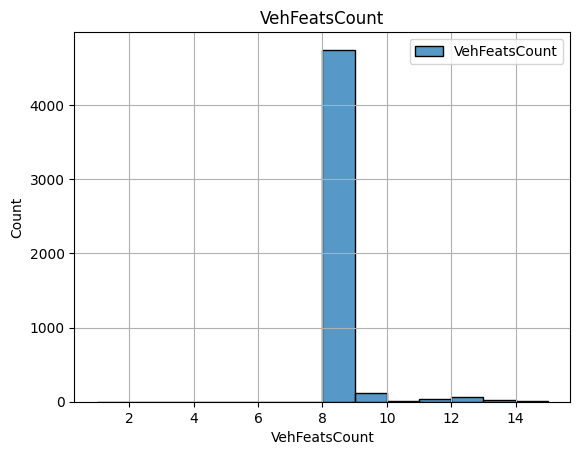

In [88]:
feature_analyzer('VehFeatsCount')

In [89]:
single_value_counts_info('VehFeatsCount')

Total count:  5012


Counts    Percent
Column        Value                   
VehFeatsCount 8        4749  94.752594
              9         114   2.274541
              12         58   1.157223
              11         39   0.778132
              13         26   0.518755
              10         12   0.239425
              15          5   0.099761
              14          4   0.079808
              1           2   0.039904
              7           2   0.039904
              6           1   0.019952

In [90]:
categorical_features.append('VehFeats')

15. VehFuel

In [91]:
feature_analyzer('VehFuel')

Categorical feature
Number of Unique values: 4
Missing values 0, % missing values 0.0

Unique Values:
['Gasoline' 'Diesel' 'E85 Flex Fuel' 'Unknown']


In [92]:
single_value_counts_info('VehFuel')

Total count:  5012


Counts    Percent
Column  Value                           
VehFuel Gasoline         4662  93.016760
        E85 Flex Fuel     310   6.185156
        Diesel             35   0.698324
        Unknown             5   0.099761

In [93]:
categorical_features.append('VehFuel')

16. VehHistory 

In [94]:
feature_analyzer('VehHistory')

Categorical feature
Number of Unique values: 32
Missing values 0, % missing values 0.0

Unique Values:
['1 Owner, Buyback Protection Eligible'
 '1 Owner, Non-Personal Use Reported, Buyback Protection Eligible'
 '1 Owner, Accident(s) Reported, Non-Personal Use Reported, Buyback Protection Eligible'
 '1 Owner, Accident(s) Reported, Buyback Protection Eligible'
 '0 Owners, Accident(s) Reported, Non-Personal Use Reported, Title Issue(s) Reported'
 '2 Owners, Non-Personal Use Reported, Buyback Protection Eligible'
 '2 Owners, Buyback Protection Eligible'
 '0 Owners, Buyback Protection Eligible'
 '1 Owner, Title Issue(s) Reported'
 '2 Owners, Accident(s) Reported, Buyback Protection Eligible'
 '0 Owners, Accident(s) Reported, Buyback Protection Eligible'
 '3 Owners, Buyback Protection Eligible'
 '1 Owner, Accident(s) Reported, Title Issue(s) Reported'
 '1 Owner, Title Issue(s) Reported, Buyback Protection Eligible'
 '0 Owners, Non-Personal Use Reported, Buyback Protection Eligible'
 '3 Owner

In [95]:
unique_labels = set()

for entry in x.VehHistory.unique():
    # Split by comma and strip each substring to remove leading/trailing spaces
    labels = [label.strip() for label in entry.split(',')]
    unique_labels.update(labels)

# Convert set back to a list
unique_labels_list = list(unique_labels)
print(unique_labels_list)

['Accident(s) Reported', '1 Owner', '2 Owners', 'Title Issue(s) Reported', '4 Owners', '3 Owners', '0 Owners', 'Non-Personal Use Reported', 'Buyback Protection Eligible']


1. Extract the number of owners.
2. Create a binary feature to indicate if accidents were reported.
3. Create a binary feature to indicate if the vehicle had non-personal use.
4. Create a binary feature to indicate if there's a title issue.
5. Create a binary feature to indicate if there's buyback protection eligibility.

In [96]:
# Extract number of owners and create a new column
x['Num_Owners'] = x['VehHistory'].str.extract(r'(\d+) Owner').astype(int)

# Check if accidents were reported
x['AccidentReported'] = x['VehHistory'].str.contains(r'Accident\(s\) Reported').astype(bool)

# Check if non-personal use was reported
x['NonPersonalUse'] = x['VehHistory'].str.contains('Non-Personal Use Reported').astype(bool)

# Check for title issues
x['TitleIssues'] = x['VehHistory'].str.contains(r'Title Issue\(s\) Reported').astype(bool)

# Check for buyback protection eligibility
x['BuybackProtection'] = x['VehHistory'].str.contains('Buyback Protection Eligible').astype(bool)


In [97]:
feature_analyzer('BuybackProtection')

Boolean feature
Missing values 0, % missing values 0.0
False count 183, True count 4829


In [98]:
single_value_counts_info('Num_Owners')


Total count:  5012


Counts    Percent
Column     Value                   
Num_Owners 1        4446  88.707103
           2         302   6.025539
           0         244   4.868316
           3          16   0.319234
           4           4   0.079808

In [99]:
single_value_counts_info('AccidentReported')


Total count:  5012


Counts    Percent
Column           Value                   
AccidentReported False    4466  89.106145
                 True      546  10.893855

In [100]:
categorical_features.append('VehHistory')

17. VehListdays

Numerical Feature


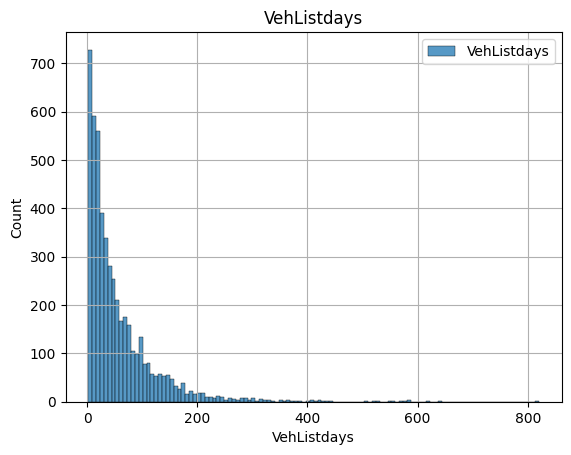

In [101]:
feature_analyzer('VehListdays')

In [102]:
x['VehListdays_log'] = np.log1p(x['VehListdays']+1)

Numerical Feature


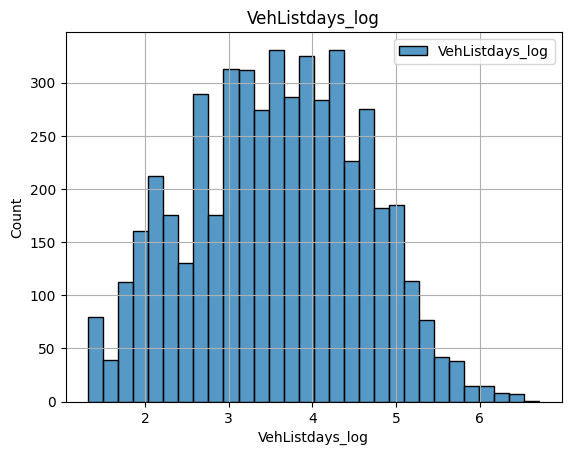

In [103]:
feature_analyzer('VehListdays_log')

In [104]:
numerical_features.append('VehListdays')

18. VehMake 

In [105]:
feature_analyzer('VehMake')

Categorical feature
Number of Unique values: 2
Missing values 0, % missing values 0.0

Unique Values:
['Jeep' 'Cadillac']


In [106]:
single_value_counts_info('VehMake')

Total count:  5012


Counts   Percent
Column  Value                     
VehMake Jeep        3395  67.73743
        Cadillac    1617  32.26257

In [107]:
categorical_features.append('VehMake')

19. VehMileage 


Numerical Feature


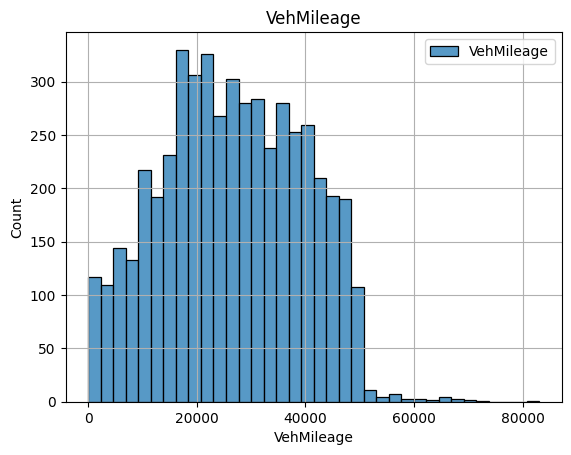

In [108]:
feature_analyzer('VehMileage')

In [109]:
numerical_features.append('VehMileage')

20. VehModel
- DROP: they are repetitive to `VehMake`

In [110]:
feature_analyzer('VehModel')

Categorical feature
Number of Unique values: 2
Missing values 0, % missing values 0.0

Unique Values:
['Grand Cherokee' 'XT5']


 21. VehPriceLabel
 - DROP!: potential data leakage

In [111]:
feature_analyzer('VehPriceLabel')

Categorical feature
Number of Unique values: 3
Missing values 0, % missing values 0.0

Unique Values:
['Good Deal' 'Great Deal' 'Fair Price']


In [112]:
single_value_counts_info('VehPriceLabel')

Total count:  5012


Counts    Percent
Column        Value                        
VehPriceLabel Good Deal     3727  74.361532
              Great Deal     725  14.465283
              Fair Price     560  11.173184

Wen need to be aware of potential **data leakage**, especially if: </br>
`VehPriceLabel` is determined using the `Dealer_Listing_Price`. In that scenario, using both could lead to over-optimistic estimates of model performance. You would need to know the exact mechanism by which VehPriceLabel is determined. If it's purely based on Dealer_Listing_Price, you might consider excluding it from the features when predicting the price to avoid this leakage.

22.  VehSellerNotes
- NLP needed!


In [113]:
feature_analyzer('VehSellerNotes')

Categorical feature
Number of Unique values: 4171
Missing values 0, % missing values 0.0

Unique Values:
['Backed by a rigorous 125-point inspection by factory-trained technicians and an additional (up to) 100,000 mile warranty, this CERTIFIED PRE-OWNED VEHICLE offers the PEACE OF MIND you&#x27;ve been searching for. ... Wilde is your one-stop shop for new Chrysler, Jeep, Dodge, Ram and SRT sales, used and certified pre-owned vehicle sales, service and parts in Southeastern Wisconsin. We are fully-stocked with hundreds of cars, trucks, mini-vans and SUVs for every budget. CALL our knowledgeable staff at 262-544-5400, learn more about us and VIEW OUR ENTIRE INVENTORY online at www.wildedodge.com or VISIT us in person, conveniently located at 1710 Hwy 164 in Waukesha, WI. We look forward to serving you! It is the policy of this dealership that prices are plus tax, tag, title, and Dealer Service Fee of $219.00. All prices, specifications and availability subject to change without notice. 

 23. VehType
- DROP: no new information

In [114]:
feature_analyzer('VehType')

Categorical feature
Number of Unique values: 1
Missing values 0, % missing values 0.0

Unique Values:
['Used']


24.  VehTransmission 
- DROP

In [115]:
feature_analyzer('VehTransmission')

Categorical feature
Number of Unique values: 27
Missing values 0, % missing values 0.0

Unique Values:
['8-Speed Automatic w/OD' 'Automatic' '8-Speed Automatic' '8-Speed A/T'
 '8-Speed Automatic (845RE)' 'AUTOMATIC' '8-Speed Shiftable Automatic'
 '8-Speed' '8 Speed Automatic' 'Automatic 8-Speed'
 '8-Spd TorqueFlite Automatic' '8-Speed Automatic (850RE)'
 '8-Speed Automatic (8HP70)' '8-Spd Auto 850RE Trans (Make'
 '8-SPEED AUTOMATIC' 'AUTO' '8-Speed TorqueFlite Automatic'
 'Automatic w/OD' '6-Speed Automatic' 'aujtomatic' 'Automatic, 8-Spd' 'A'
 '8 speed automatic' 'Not Specified' '8-Spd Auto 850RE Trans (Make)'
 'automatic' 'Shiftable Automatic']


25.  VehYear   


In [116]:
CURRENT_YEAR = 2023
# the older the car the cheaper it can be
x['VehAge'] = CURRENT_YEAR - x['VehYear']

Numerical Feature


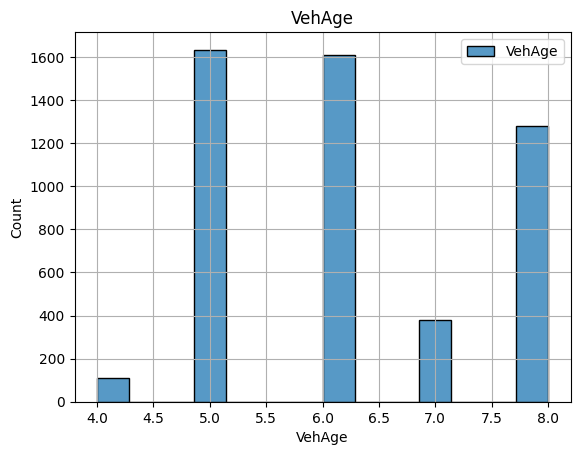

In [117]:
feature_analyzer('VehAge')

In [118]:
numerical_features.append('VehYear')

# Create a function for processing features
- will be used for the test as well

In [119]:
# Load the datasets
df = pd.read_csv('data/Training_dataset.csv')
test_df = pd.read_csv('data/Test_dataset.csv')

In [120]:
def preprocessing(df):
    
    CURRENT_YEAR = 2023

    def one_hot_fn(dataframe: pd.DataFrame, feature_name: str):
        # One-hot encode the 'feature' column
        encoded_columns = pd.get_dummies(dataframe[feature_name], prefix=feature_name)
        # Drop the original 'feature' column
        dataframe.drop(feature_name, axis=1, inplace=True)
        # Concatenate the original DataFrame and the one-hot encoded columns
        dataframe = pd.concat([dataframe, encoded_columns], axis=1)
        return dataframe
    
    # DONE
    def veh_drive_train_transform(df):
        drivetrain_mapping = {
        '4x4/4WD': 'all_drive',
        '4WD': 'all_drive',
        'FWD': 'front_drive',
        'AWD': 'all_drive',
        '4x4': 'all_drive',
        'Four Wheel Drive': 'all_drive',
        '4X4': 'all_drive',
        'All Wheel Drive': 'all_drive',
        'ALL-WHEEL DRIVE WITH LOCKING AND LIMITED-SLIP DIFFERENTIAL': 'all_drive',
        'AWD or 4x4': 'all_drive',
        'Front Wheel Drive': 'all_drive',
        'All-wheel Drive': 'all_drive',
        'ALL WHEEL': 'all_drive',
        'AllWheelDrive': 'all_drive',
        '4WD/AWD': 'all_drive'}

        df['VehDrive'] = df['VehDriveTrain'].replace(drivetrain_mapping)
        # Determine the most frequent value after mapping
        most_frequent = df['VehDrive'].mode()[0]
        # Replace NaN values with the most frequent value
        df['VehDrive'].fillna(most_frequent, inplace=True)
        
        # Handle unknown categories
        known_values = set(drivetrain_mapping.values())
        df.loc[~df['VehDrive'].isin(known_values), 'VehDrive'] = 'other'
        
        # one hot encode
        df = one_hot_fn(df, 'VehDrive')
        df.drop('VehDriveTrain', axis=1, inplace=True)
        return df
    
    # DONE
    def veh_feats_transform(df):
        # Perform mapping to count the features per vehicle
        df['VehFeatsCount'] = df['VehFeats'].apply(lambda x: len(str(x).split(',')) if not pd.isna(x) else None)
        # Determine the most frequent count value
        most_frequent = df['VehFeatsCount'].mode()[0]
        # Use the most frequent value for imputation of NaN values
        df['VehFeatsCount'].fillna(most_frequent, inplace=True)
        # Drop the original 'VehFeats' column
        df.drop('VehFeats', axis=1, inplace=True)

        return df

    # DONE
    def veh_color_ext_transform(df):
        # NaNs will be filled with color White! - most popular color
        def basic_color(color):
            if pd.isna(color):
                return 'White'
            elif not isinstance(color, str):
                return 'Other'

            base_colors = ['Black', 'White', 'Red', 'Silver', 'Blue', 'Gray', 'Brown', 'Gold']
            for base in base_colors:
                if base.lower() in color.lower():
                    return base
            return 'Other'

        df['BasicExtColor'] = df['VehColorExt'].apply(basic_color)
        df.drop('VehColorExt', axis=1, inplace=True)
        df = one_hot_fn(df, 'BasicExtColor')
        
        return df
    
    # DONE!
    def veh_color_int_transform(df):
        # Nans -> False/ 0 (because non-leather cars are more popular)
        df['ContainsLeather'] = df['VehColorInt'].str.contains('leather', case=False, na=False).astype(bool)
        df.drop('VehColorInt', axis=1, inplace=True)
        df['ContainsLeather'] = df['ContainsLeather'].astype(int)
        return df
    
    # DONE
    def veh_engine_transform(df):
        def get_displacement(engine):
            if pd.isna(engine) or not isinstance(engine, str):
                return 0
            match = re.search(r'(\d+\.\d+)', engine)
            return float(match.group(1)) if match else 0

        df['Displacement'] = df['VehEngine'].apply(get_displacement)

        engine_types = ['turbo', 'supercharged', 'diesel', 'hemi']

        def categorize_engine(engine):
            if pd.isna(engine) or not isinstance(engine, str):
                return 'Other'
            for etype in engine_types:
                if etype in engine.lower():
                    return etype.capitalize()
            return 'Other'

        df['Engine_Category'] = df['VehEngine'].apply(categorize_engine)
        df.drop('VehEngine', axis=1, inplace=True)

        # Assuming one_hot_fn is a function that takes in a dataframe and a column name to one-hot encode.
        df = one_hot_fn(df, 'Engine_Category')
        return df
    
    #DONE
    def veh_history_transform(df):
        # Extract number of owners and create a new column
        df['Num_Owners'] = df['VehHistory'].str.extract(r'(\d+) Owner')

        # Check if accidents were reported
        df['AccidentReported'] = df['VehHistory'].str.contains(r'Accident\(s\) Reported')

        # Check if non-personal use was reported
        df['NonPersonalUse'] = df['VehHistory'].str.contains('Non-Personal Use Reported')

        # Check for title issues
        df['TitleIssues'] = df['VehHistory'].str.contains(r'Title Issue\(s\) Reported')

        # Check for buyback protection eligibility
        df['BuybackProtection'] = df['VehHistory'].str.contains('Buyback Protection Eligible')

        # Impute NaNs for each new feature using the most frequent value of that feature
        new_features = ['Num_Owners', 'AccidentReported', 'NonPersonalUse', 'TitleIssues', 'BuybackProtection']
        for feature in new_features:
            most_common = df[feature].mode()[0]
            df[feature].fillna(most_common, inplace=True)

        # Convert boolean and object columns to integers
        df['Num_Owners'] = df['Num_Owners'].astype(int)
        df['AccidentReported'] = df['AccidentReported'].astype(int)
        df['NonPersonalUse'] = df['NonPersonalUse'].astype(int)
        df['TitleIssues'] = df['TitleIssues'].astype(int)
        df['BuybackProtection'] = df['BuybackProtection'].astype(int)

        # Drop the original 'VehHistory' column
        df.drop('VehHistory', axis=1, inplace=True)
        return df
    
    # DONE
    def veh_make_transform(df):
        vehmake_mapping = {
        "Jeep": 1,
        "Cadillac": 0}

        df['Is_Jeep'] = df['VehMake'].map(vehmake_mapping)
        df.drop('VehMake', axis=1, inplace=True)
        return df
    
    # DONE
    def veh_mileage_transform(df):
        # Calculate the mean of the 'VehMileage' column
        mileage_mean = df['VehMileage'].mean()
        # Impute NaN values in the 'VehMileage' column with the computed mean
        df['VehMileage'].fillna(mileage_mean, inplace=True)
        return df

    df.set_index('ListingID', inplace=True)

    # dropping unused features
    unused_features = ['VehTransmission','VehBodystyle','SellerZip','VehType','VehSellerNotes',
                       'VehPriceLabel','VehModel','SellerIsPriv','SellerName','SellerCity']
    
    df = df.drop(unused_features, axis=1)
    
    # features requiring one-hot-encoding
    df = one_hot_fn(df, 'SellerListSrc')
    df = one_hot_fn(df, 'VehFuel')
    df = one_hot_fn(df, 'SellerState')

    # features requiring log transform
    df['SellerRevCnt'] = np.log1p(df['SellerRevCnt'])
    df['VehListdays'] = np.log1p(df['VehListdays'])

    # new feature
    df['VehAge'] = CURRENT_YEAR - df['VehYear']
    df.drop('VehYear', axis=1, inplace=True)
    
    # boolean encoding
    df['VehCertified'] = df['VehCertified'].astype(int)
    
    # new feature
    df = veh_drive_train_transform(df)
    df = veh_feats_transform(df)
    df = veh_color_ext_transform(df)
    df = veh_color_int_transform(df)
    df = veh_engine_transform(df)
    df = veh_history_transform(df)
    df = veh_make_transform(df)
    df = veh_mileage_transform(df)
    
    # drop any remaining nans
    df = df.dropna()

    
    # deal with badly parsed column names
    df.columns = [col.replace(' ', '_') for col in df.columns]
    

    return df


def preprocessing_target_features(df):
    
    df = df.dropna(subset=['Vehicle_Trim', 'Dealer_Listing_Price'])

    # Mapping dictionary
    jeep_mapping = {
        'Limited 75th Anniversary Edition': 'Limited',
        'Limited X': 'Limited',
        'Limited 4x4': 'Limited',
        'Limited 75th Anniversary': 'Limited',

        'Laredo E': 'Laredo',

        'SRT Night': 'SRT',

        'Summit': 'Overland',

        'Trackhawk': 'Trailhawk',

        'High Altitude': 'Altitude'}

    # Replace and groupby
    df['Vehicle_Trim'] = df['Vehicle_Trim'].replace(jeep_mapping)
    # dropping 
    jeep_drop_trims = ['75th Anniversary Edition', 'Upland','75th Anniversary','Sterling Edition']

    df = df[~df['Vehicle_Trim'].isin(jeep_drop_trims)]

    # Mapping dictionary
    cadillac_mapping = {
        'Premium Luxury AWD': 'Premium',
        'Premium Luxury FWD': 'Premium',
        'Premium Luxury': 'Premium',

        'Luxury FWD': 'Luxury',
        'Luxury': 'Luxury',
        'Luxury AWD': 'Luxury',

        'Base': 'Base',
        'FWD': 'Base',

        'Platinum': 'Platinum',
        'Platinum AWD': 'Platinum'}

    # Replace and groupby
    df['Vehicle_Trim'] = df['Vehicle_Trim'].replace(cadillac_mapping)
    
    return df

In [121]:
df.columns

Index(['ListingID', 'SellerCity', 'SellerIsPriv', 'SellerListSrc',
       'SellerName', 'SellerRating', 'SellerRevCnt', 'SellerState',
       'SellerZip', 'VehBodystyle', 'VehCertified', 'VehColorExt',
       'VehColorInt', 'VehDriveTrain', 'VehEngine', 'VehFeats', 'VehFuel',
       'VehHistory', 'VehListdays', 'VehMake', 'VehMileage', 'VehModel',
       'VehPriceLabel', 'VehSellerNotes', 'VehType', 'VehTransmission',
       'VehYear', 'Vehicle_Trim', 'Dealer_Listing_Price'],
      dtype='object')

In [122]:
df.shape

(6298, 29)

In [123]:
df.columns

Index(['ListingID', 'SellerCity', 'SellerIsPriv', 'SellerListSrc',
       'SellerName', 'SellerRating', 'SellerRevCnt', 'SellerState',
       'SellerZip', 'VehBodystyle', 'VehCertified', 'VehColorExt',
       'VehColorInt', 'VehDriveTrain', 'VehEngine', 'VehFeats', 'VehFuel',
       'VehHistory', 'VehListdays', 'VehMake', 'VehMileage', 'VehModel',
       'VehPriceLabel', 'VehSellerNotes', 'VehType', 'VehTransmission',
       'VehYear', 'Vehicle_Trim', 'Dealer_Listing_Price'],
      dtype='object')

In [124]:
preprocessed_df = preprocessing(df)
df_final = preprocessing_target_features(preprocessed_df)

In [125]:
null_columns = df_final.columns[df_final.isnull().sum() > 0]
print(null_columns)

Index([], dtype='object')


In [126]:
df_final.Is_Jeep.value_counts()

1    3990
0    1811
Name: Is_Jeep, dtype: int64